# Linear Regression

This notebook builds a simple linear regression model.
- Derives the MLE solution for estimating weights under Gaussian noise
- Verifies the closed-form least squares solution using gradient descent
- Implements Bayesian inference with Gaussian priors
- Visualizes predictive uncertainty from the posterior

## Setup

In [19]:
import numpy as np
import matplotlib.pyplot as plt

## MLE for Linear Regression with Gaussian Noise

We're modeling outputs of $y \in \mathbb{R}^n$ as noisy linear combinations of inputs $X \in \mathbb{R}^{n \times d}$:

$$y = X w + \epsilon$$

Where: 
- $x_i \in \mathbb{R}^d$ is the $i$-th row of $X$, representing one data point
- $w \in \mathbb{R}^d$ is the parameter vector
- Each output $y_i$ is given by $y_i = x_i^T w + \epsilon_i$
- The noise term $\epsilon \sim \mathcal{N}(0, \sigma^2 I_n)$ is i.i.d. gaussian

Conditioned on $X$, the outputs are:

$$y \mid X \sim \mathbb{N}(X w, \sigma^2 I)$$

When $d = 1$, we are fitting a line and when $d = 2$, we are fitting a plane. Also, note that there is no bias term although that could be added by adjusting the model.

$$X' = \begin{bmatrix} X & \mathbf{1} \end{bmatrix}, w' = \begin{bmatrix} w \\ b \end{bmatrix}$$

### Likelihood

The probability density function of $y$ is the following.

$$ p(y | X, w, \sigma^2) = \prod_{i=1}^{n} \mathcal{N}(y_i | x_i^T w, \sigma^2)$$

Where:

$$\mathcal{N}(y_i | x_i^T w, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp (-\frac{1}{2 \sigma^2} (y_i - x_i^T w)^2)$$

When we want the log-likelihood and remove the constants, we get the following.

$$\log(p(y | X, w, \sigma^2)) \sim -\sum_{i=1}^{n} (y_i - x_i^T w)^2 \sim -||y - Xw||^2$$

This means that maximizing the log-likelihood is equivalent to minimizing the squared error.

$$\min_{w} ||y - Xw||^2$$

### Closed-form Solution

We can find the formula for the weights that minimize the least squared error by solving for the closed-form solution. 

$$L(w) = ||y - Xw||^2 = y^T y - 2 w^T X^T y + w^T X^T X w$$

So, we take the derivative of the loss.

$$
\begin{align}
\frac{d}{dw} L(w) &= -2 X^T y + 2 X^T X w \\
&= -2 X^T (y - Xw)
\end{align}
$$

We can set the derivative for $0$ and solve for $w$.

$$
\begin{align}
-2 X^T (y - Xw) &= 0 \\
X^T (y - Xw) &= 0 \\
X^T y &= X^T Xw \\
w &= (X^T X)^{-1} X^T y
\end{align}
$$

Thus, the least squares solution is the following.

$$w = (X^T X)^{-1} X^T y$$

In [2]:
def linear_regression_mle(X, y):
    """
    Linear regression closed-form solution (MLE under Gaussian noise)

    Args:
        X: Feature matrix of shape (n_samples, n_features)
        y: Target vector of shape (n_samples,)

    Returns:
        Weight vector w that minimizes squared error, of shape (n_features,)
    """
    return np.linalg.inv(X.T @ X) @ X.T @ y

### Verifying using Gradient Descent

We're trying to minimize the negative log-likelihood:

$$L(w) = ||y - Xw||^2$$

The gradient of the loss tells us the direction of steepest increase in loss, so moving in the opposite direction leads us toward lower loss.

$$\frac{d}{dw} L(w) = -2X^T(y - Xw)$$

In [6]:
def linear_regression_gradient(w, X, y):
    """
        Computes the gradient of the squared loss for linear regression

        Args:
            w: Current weight vector of shape (n_features,)
            X: Feature matrix of shape (n_samples, n_features)
            y: Target vector of shape (n_samples,)

        Returns:
            Gradient vector of shape (n_features,)
    """
    return -2 * X.T @ (y - X @ w)

We're modeling outputs generated by a plane with added Gaussian noise. Using gradient descent, we find the weights that maximize the likelihood, which is equivalent to minimizing the squared error loss.

In [7]:
# Fitting a plane
n_features = 2

# Generate true weights
w_true = np.array([0.5, 0.5])  # np.random.rand(n_features)
print('w_true:', w_true)

# Generate random samples
n_samples = 1000
X = np.random.rand(n_samples, n_features)

# Generate noise (multiplying by sigma transforms N(0, 1) to N(0, sigma^2))
sigma = 2
epsilon = np.random.randn(n_samples) * sigma

# Generate labels for samples
y = X @ w_true + epsilon

# Find estimated weights using closed-form MLE solution
w_mle = linear_regression_mle(X, y)
print('w_mle:', w_mle)

# Verify closed-form solution using gradient descent
w_grad = np.array([0.0, 0.0])
learning_rate = 0.001
learning_rate_decay = 0.9
for i in range(1000):
    grad_vec = linear_regression_gradient(w_grad, X, y)
    w_grad = w_grad - learning_rate * grad_vec
    learning_rate *= learning_rate_decay
print('w_grad:', w_grad)

w_true: [0.5 0.5]
w_mle: [0.53015294 0.65566135]
w_grad: [0.54363963 0.64144966]


## Bayesian Linear Regression

We're using Bayesian inference to:
- Compute the posterior distribution over the weights given a prior distribution and likelihood
- Sample from this posterior to visualize the predictive uncertainty
- Show how confidence intervals shrink where data is dense and grow where data is sparse

### Posterior Distribution

For Bayesian inference, instead of treating $w$ as a variable, we treat it as a random variable. Let's assume that the prior over the weights is Gaussian.

$$w \sim \mathcal{N}(0, \sigma_w^2 I) \propto \exp(-\frac{1}{2\sigma_w^2}||w||^2)$$

As in the MLE exercise, we're modeling a linear model with Gaussian noise so the likelihood is Gaussian conditioned on $X$ and $w$.

$$y | X, w \sim \mathcal{N}(Xw, \sigma^2 I) \propto \exp(-\frac{1}{2\sigma^2}||y - Xw||^2)$$

Now that we have both the prior and likelihood, we can compute the posterior distribution using Bayes' Theorem.

$$p(w | X, y) \propto p(y | X, w) \cdot p(w)$$

There is a lengthy derivation on how to find resulting mean $\mu_{post}$ and covariance $\Sigma_{post}$ that starts with the following.

$$
\begin{align}
\log p(w | X, y) &\propto \log p(y | X, w) + \log p(w) \\
&= -\frac{1}{2\sigma^2}(y - Xw)^T(y - Xw) - \frac{1}{2\sigma_w^2}w^T w + \text{const}
\end{align}$$

Eventually, we find that the posterior distribution is the following.

$$
\begin{align}
w | X, y &\sim \mathcal{N}(\mu_{post}, \Sigma_{post}) \\
\Sigma_{post} &= (\frac{1}{\sigma^2} X^T X + \frac{1}{\sigma_w^2} I)^{-1} \\
\mu_{post} &= \Sigma_{post}(\frac{1}{\sigma^2}X^T y)
\end{align}
$$

In [78]:
def compute_posterior_covariance(X, sigma, sigma_w):
    """
    Computes the posterior covariance matrix of the weights in Bayesian linear regression.

    Args:
        X: Feature matrix of shape (n_samples, n_features)
        sigma: Standard deviation of the observation noise
        sigma_w: Standard deviation of the prior over weights

    Returns:
        Posterior covariance matrix of shape (n_features, n_features)
    """
    n_features = X.shape[1]
    return np.linalg.inv((1 / sigma**2) * X.T @ X + (1 / sigma_w**2) * np.eye(n_features))

def compute_posterior_mean(X, y, sigma, sigma_w):
    """
    Computes the posterior mean of the weights in Bayesian linear regression.

    Args:
        X: Feature matrix of shape (n_samples, n_features)
        y: Target vector of shape (n_samples,)
        sigma: Standard deviation of the observation noise
        sigma_w: Standard deviation of the prior over weights

    Returns:
        Posterior mean vector of shape (n_features,)
    """
    covar = compute_posterior_covariance(X, sigma, sigma_w)
    return covar @ ((1 / sigma**2) * X.T @ y)

We're modeling outputs that are generated from a line with some added Gaussian noise and applying Bayesian linear regression.

In [79]:
# Fitting a line
n_features = 1

# Generate true weights
w_true = np.array([0.5])  # np.random.rand(n_features)
print('w_true:', w_true)

# Generate random samples
n_samples = 100
X = np.random.rand(n_samples, n_features)

# Generate noise (multiplying by sigma transforms N(0, 1) to N(0, sigma^2))
sigma = 0.5
epsilon = np.random.randn(n_samples) * sigma

# Generate labels for samples
y = X @ w_true + epsilon

w_true: [0.5]


We compute the mean and covariance of the posterior distribution. Using the posterior distribution over the weights, we can compute the predictive mean and uncertainty at each test input.

In [80]:
# Assume a variance for the prior distribution
sigma_w = 0.1

w_mean = compute_posterior_mean(X, y, sigma, sigma_w)
w_covar = compute_posterior_covariance(X, sigma, sigma_w)
print('posterior mean:', w_mean)
print('posterior covariance mat:', w_covar)

# Generate a test grid
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

y_mean = X_test @ w_mean
y_var = np.array([x.T @ w_covar @ x + sigma**2 for x in X_test])
y_std = np.sqrt(y_var)

posterior mean: [0.29870273]
posterior covariance mat: [[0.00416414]]


We can visualize the predictive mean and uncertainty at at each test input.

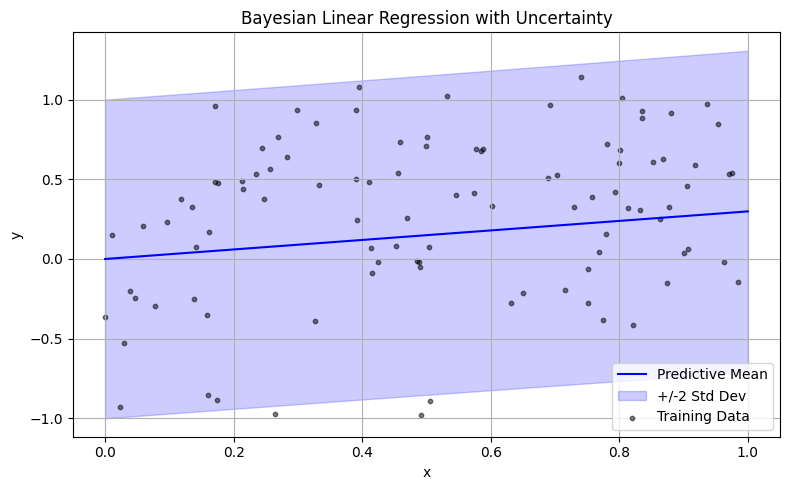

In [81]:
plt.figure(figsize=(8, 5))

# Plot the predictive mean line
plt.plot(X_test, y_mean, label='Predictive Mean', color='blue')

# Plot the confidence interval (+/-2 std)
plt.fill_between(
    X_test.ravel(),
    y_mean - 2 * y_std,
    y_mean + 2 * y_std,
    color='blue',
    alpha=0.2,
    label='+/-2 Std Dev'
)

# Plot the training data
plt.scatter(X, y, color='black', s=10, alpha=0.5, label='Training Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Linear Regression with Uncertainty')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Let's see what happens when we have uneven sample data and how that affects the confidence intervals.

w_true: [0.5]
posterior mean: [0.38071132]
posterior covariance mat: [[0.28306232]]


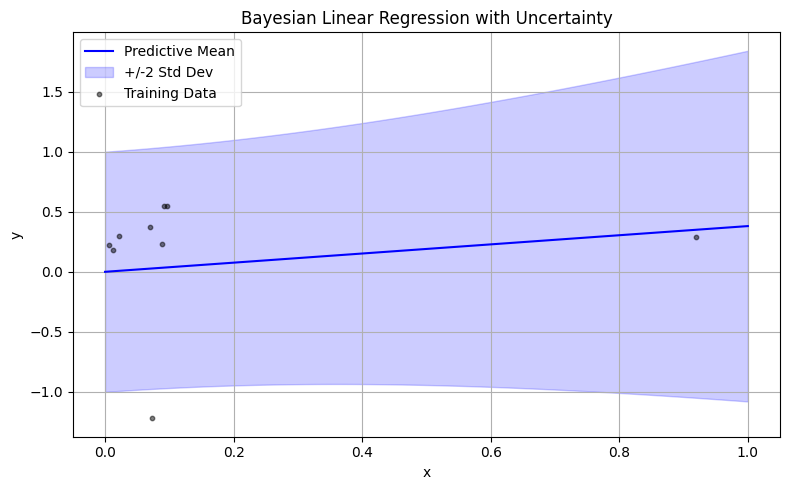

In [77]:
# Fitting a line
n_features = 1

# Generate true weights
w_true = np.array([0.5])  # np.random.rand(n_features)
print('w_true:', w_true)

# Generate random samples
n_samples = 9
X_dense = np.random.uniform(0.0, 0.1, size=(8, 1))
X_sparse = np.random.uniform(0.9, 1.0, size=(1, 1))
X = np.vstack([X_dense, X_sparse])

# Generate noise (multiplying by sigma transforms N(0, 1) to N(0, sigma^2))
sigma = 0.5
epsilon = np.random.randn(n_samples) * sigma

# Generate labels for samples
y = X @ w_true + epsilon


# Assume a variance for the prior distribution
sigma_w = 10.0

w_mean = compute_posterior_mean(X, y, sigma, sigma_w)
w_covar = compute_posterior_covariance(X, sigma, sigma_w)
print('posterior mean:', w_mean)
print('posterior covariance mat:', w_covar)

# Generate a test grid
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

y_mean = X_test @ w_mean
y_var = np.array([x.T @ w_covar @ x + sigma**2 for x in X_test])
y_std = np.sqrt(y_var)


# Visualize predictive mean line
plt.figure(figsize=(8, 5))

# Plot the predictive mean line
plt.plot(X_test, y_mean, label='Predictive Mean', color='blue')

# Plot the confidence interval (+/-2 std)
plt.fill_between(
    X_test.ravel(),
    y_mean - 2 * y_std,
    y_mean + 2 * y_std,
    color='blue',
    alpha=0.2,
    label='+/-2 Std Dev'
)

# Plot the training data
plt.scatter(X, y, color='black', s=10, alpha=0.5, label='Training Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Linear Regression with Uncertainty')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
